## Lecture-04
### 1. Data 
+ Pre-processing 
+ Feature-Extractor
+ Split Training, Test, Validation
+ Build Model
+ Gradient Descent 
+ Evaluation
+ Predicat
+ Analysis

## House Price Regression

### Load Data

In [48]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd

In [4]:
data = load_boston()

In [6]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [7]:
import pandas as pd
dataframe = pd.DataFrame(data['data'])

In [8]:
dataframe.columns = data['feature_names']

In [22]:
from collections import Counter
for index in dataframe.columns:
    print(index,': ',len(Counter(dataframe[index])))

CRIM :  504
ZN :  26
INDUS :  76
CHAS :  2
NOX :  81
RM :  446
AGE :  356
DIS :  412
RAD :  9
TAX :  66
PTRATIO :  46
B :  357
LSTAT :  455


### CHAS RAD 均为浮点型，需转换为categorical类型

In [34]:
##
dataframe[dataframe['CHAS'] == 1].head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
142,3.32105,0.0,19.58,1,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82
152,1.12658,0.0,19.58,1,0.871,5.012,88.0,1.6102,5,403.0,14.7,343.28,12.12
154,1.41385,0.0,19.58,1,0.871,6.129,96.0,1.7494,5,403.0,14.7,321.02,15.12
155,3.53501,0.0,19.58,1,0.871,6.152,82.6,1.7455,5,403.0,14.7,88.01,15.02
160,1.27346,0.0,19.58,1,0.605,6.250,92.6,1.7984,5,403.0,14.7,338.92,5.50


### Pre-processing

In [26]:
dataframe['CHAS'] = dataframe['CHAS'].astype('int')
dataframe['CHAS'] = dataframe['CHAS'].astype('category')
dataframe['RAD'] = dataframe['RAD'].astype('int')
dataframe['RAD'] = dataframe['RAD'].astype('category')
dataframe['RAD']

0      1
1      2
2      2
3      3
4      3
      ..
501    1
502    1
503    1
504    1
505    1
Name: RAD, Length: 506, dtype: category
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 24]

### Categeracal 的编码方式（必须处理，因为数值只是为了区分，无实际的数值含义，在计算距离的算法上会有问题）
+ one-hot （因为维度增加，一般都是调用sklearn的api，用sparse matrix保存）
+ embedding(需要预训练得到有效的embedding，比如拿别人训练好的城市（背后包含了gdp 人口等），北上广深的embedding距离是近的)

这里使用one-hot (s)

In [30]:
from sklearn.preprocessing import OneHotEncoder
onehoter = OneHotEncoder()
chas_and_rad_vec = onehoter.fit_transform(dataframe[['CHAS', 'RAD']])
chas_and_rad_vec

<506x11 sparse matrix of type '<class 'numpy.float64'>'
	with 1012 stored elements in Compressed Sparse Row format>

In [38]:
chas_and_rad_vec.toarray().shape
chas_and_rad_vec.toarray()[152]

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

### 连续性 的编码方式（不同特征维度量纲不同，会导致wx的系数w的梯度变化有的大有的小）
#### 缺点
+ 梯度学习时间变长，会出现梯度爆炸or消失的情况
+ 不在一个量纲，系数不便于特征之间比较，（不能代表特征的权重）

#### 标准化/归一化方法
+ min-max scalization: (x-min)/(max-min)   0-1的值，----适合都很大、or都很小的数字
+ standarlization: (x-mean)/std 转换为标准正态，----适合数据方差过小（集中）or过大（分散）
+ log(log(log(x))): 财富等特别偏的数据（越偏越做多次log）


In [40]:
import matplotlib.pyplot as plt

In [46]:
real_vec = dataframe.drop(columns=['CHAS', 'RAD'])
real_vec

(506,)

In [63]:
def show_continues(x,width=4):
    fig, ax = plt.subplots(x.shape[1]//width + 1, width, figsize=(20, 20))

    for i,col in enumerate(x.columns):
        ix = np.unravel_index(i, ax.shape)
        plt.sca(ax[ix])
        ax[ix].title.set_text('Feature-{}'.format(col))
        plt.hist(x[col])

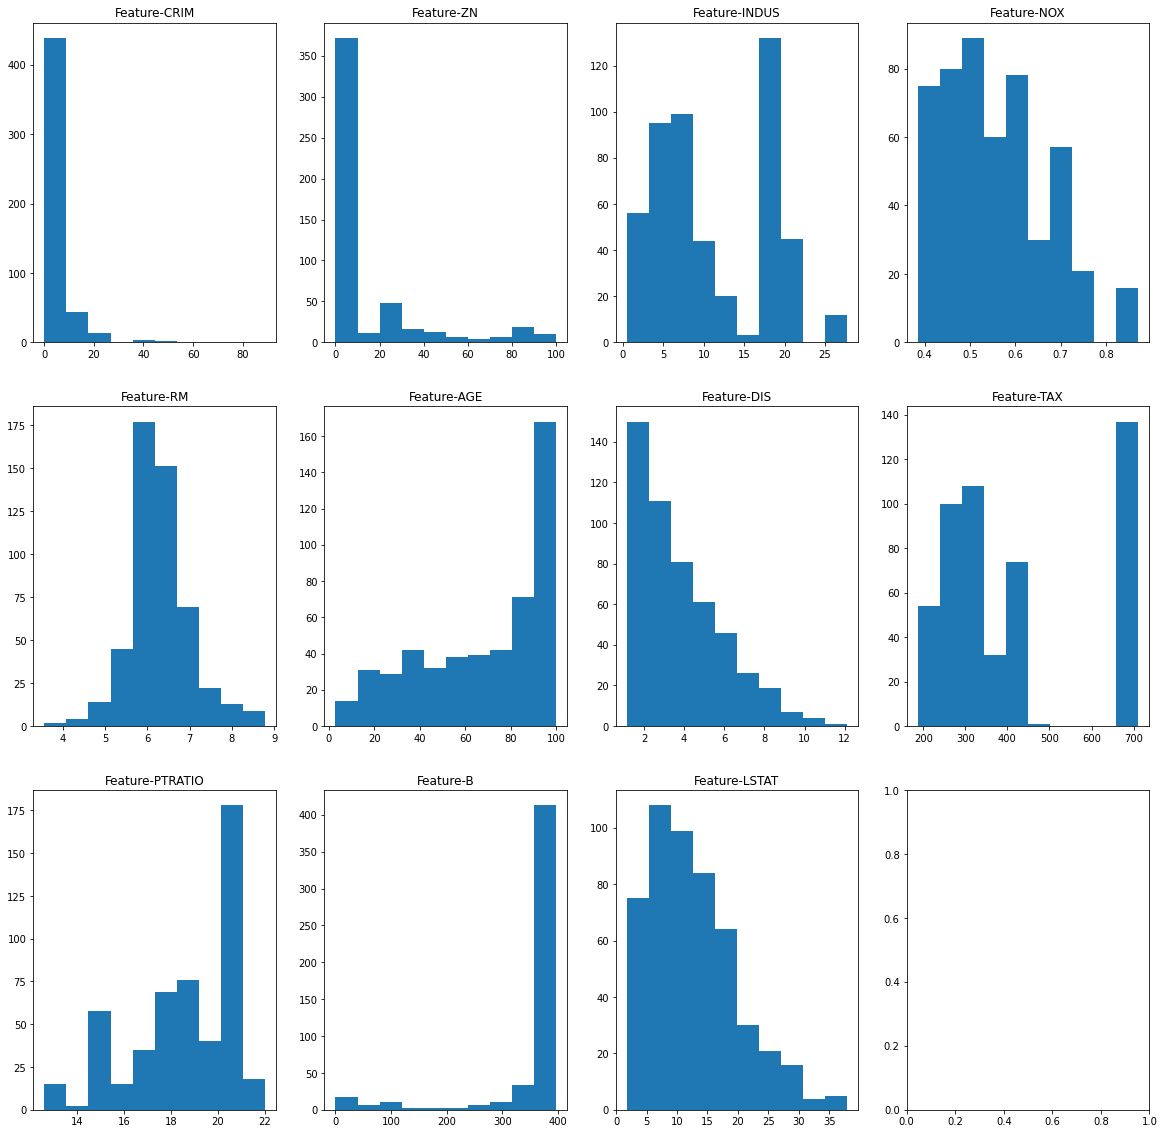

In [64]:
show_continues(real_vec)

In [66]:
from sklearn.preprocessing import StandardScaler
stander = StandardScaler()

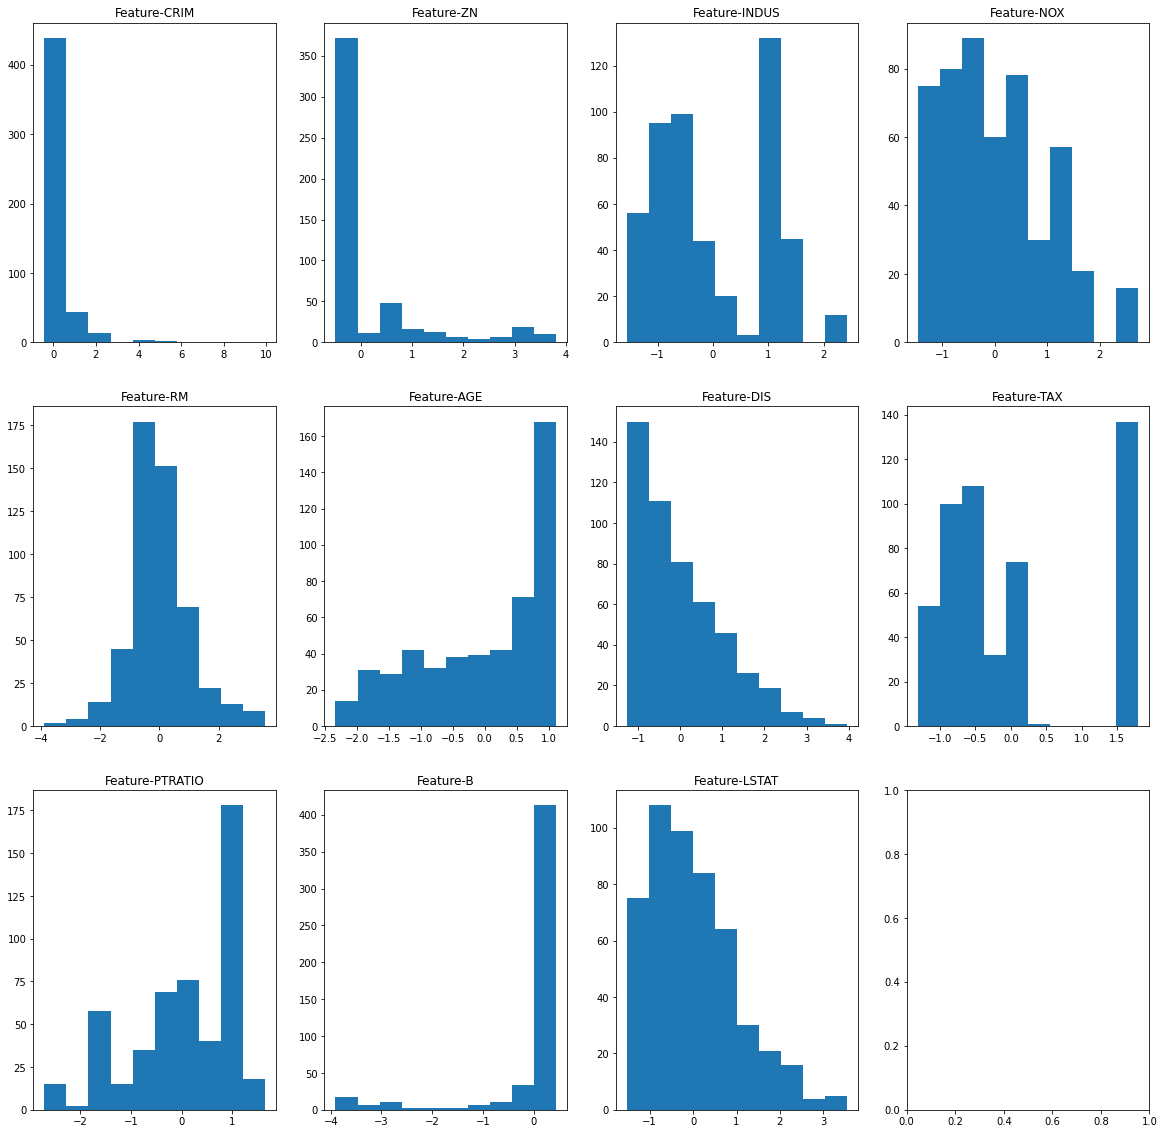

In [68]:
show_continues(pd.DataFrame(stander.fit_transform(real_vec),columns=real_vec.columns))

(array([  3.,  13.,  23.,  52.,  74.,  81., 101.,  90.,  48.,  21.]),
 array([0.54812141, 0.85698891, 1.1658564 , 1.4747239 , 1.78359139,
        2.09245889, 2.40132639, 2.71019388, 3.01906138, 3.32792888,
        3.63679637]),
 <a list of 10 Patch objects>)

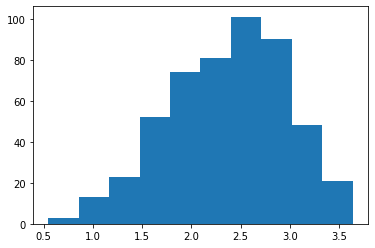

In [73]:
plt.hist(np.log(real_vec['LSTAT']))

In [76]:
stander_vec = stander.fit_transform(real_vec)

In [81]:
chas_and_rad_vec.toarray().shape

(506, 11)

In [78]:
stander_vec.shape

(506, 11)

### Feature-Extractor

In [83]:
X = np.concatenate((stander_vec, chas_and_rad_vec.toarray()), axis=1)
X.shape

(506, 22)

In [87]:
y = data['target']
y.shape

(506,)

### Split Training, Test, Validation
#### sklearn.model_selection.train_test_split also could be used

In [85]:
def split_train_val_test(X, y, test_ratio=0.2, val_ratio=0.2):
    indices = np.random.choice(range(len(X)), size=len(X), replace=False)
    
    train_indices = indices[:int(len(X)*(1-test_ratio)*(1-val_ratio))]
    val_indices = indices[int(len(X)*(1-test_ratio)*(1-val_ratio)): int(len(X)*(1-test_ratio))]
    test_indices = indices[int(len(X)*(1-test_ratio)):]
    
    return (X[train_indices], y[train_indices]), (X[val_indices], y[val_indices]), (X[test_indices], y[test_indices])  

In [88]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_train_val_test(X, y)

### Build-Model

#### built-in sklearn model

In [93]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

In [94]:
lr_model.fit(X_train,y_train)

LinearRegression()

#### user-defined LR model

In [100]:
X_train.shape

(323, 22)

In [144]:
w, b = np.random.rand(22), np.random.random()
learning_rate = 1e-2
for i in range(100000):
    y_hats = np.dot(X_train, w) + b * np.ones(323)
    loss = np.mean((y_hats - y_train)**2)
    if i%10000==0:
        print('loss is: ', loss)
    gradient_descent = np.array([np.mean((y_hats - y_train) * X_train[:,col]) for col in range(X_train.shape[1])])
    w = w - gradient_descent * learning_rate
    b = b - np.mean(y_hats - y_train) * learning_rate

print(w)

loss is:  557.0115030551232
loss is:  19.375799466717382
loss is:  19.37489418439666
loss is:  19.374878048130636
loss is:  19.374877661657518
loss is:  19.374877652304207
loss is:  19.37487765207777
loss is:  19.374877652072286
loss is:  19.37487765207215
loss is:  19.37487765207215
[-0.92298944  1.21736087 -0.24762524 -1.52237552  3.033201   -0.22162792
 -2.72370979 -1.37903753 -1.72685873  1.27047194 -3.26414705  5.91671932
  9.21784321 -0.52102601  0.10472943  3.29867897  0.89713734  1.56106057
  0.36262939  2.96909779  2.53250003  6.13391049]


## Question: If overfittiing or underfitting? 
### Explain: Why validation set is more useful in deep learning
### Gradient Descent

### Evaluation

In [96]:
lr_model.score(X_train,y_train)

0.7687360278723439

In [97]:
lr_model.score(X_val,y_val)

0.6237743913187136

In [98]:
lr_model.score(X_test,y_test)

0.7512384897883686

## Interpreter

In [99]:
lr_model.coef_

array([-0.92298944,  1.21736087, -0.24762524, -1.52237552,  3.033201  ,
       -0.22162792, -2.72370979, -1.37903753, -1.72685873,  1.27047194,
       -3.26414705, -1.65056195,  1.65056195, -2.44755023, -1.8217948 ,
        1.37215475, -1.02938689, -0.36546365, -1.56389483,  1.04257357,
        0.60597581,  4.20738627])

In [161]:
lr_model.intercept_

23.235268503064088

## Predict

In [141]:
y_pred = lr_model.predict(X_train)

In [143]:
loss = np.mean((y_pred - y_train)**2)
print(loss)

19.37487765207215


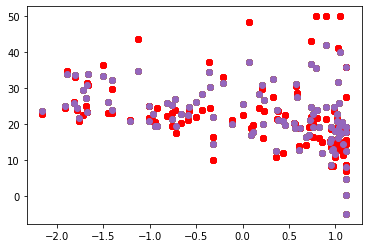

In [150]:
for i in range(5):
    plt.scatter(X_test[:, 5], y_test, c='red')
    plt.scatter(X_test[:, 5], lr_model.predict(X_test))

In [158]:
def show_predication_result(x, target, predict):
    width = 3

    fig, ax = plt.subplots(x.shape[1]//width + 1, width, figsize=(40, 40))

    for i in range(x.shape[1]):
        ix = np.unravel_index(i, ax.shape)
        plt.sca(ax[ix])
        ax[ix].title.set_text('Feature-{}'.format(i))
        plt.scatter(x[:, i], target, c='blue')
        plt.scatter(x[:, i], predict, c='red')

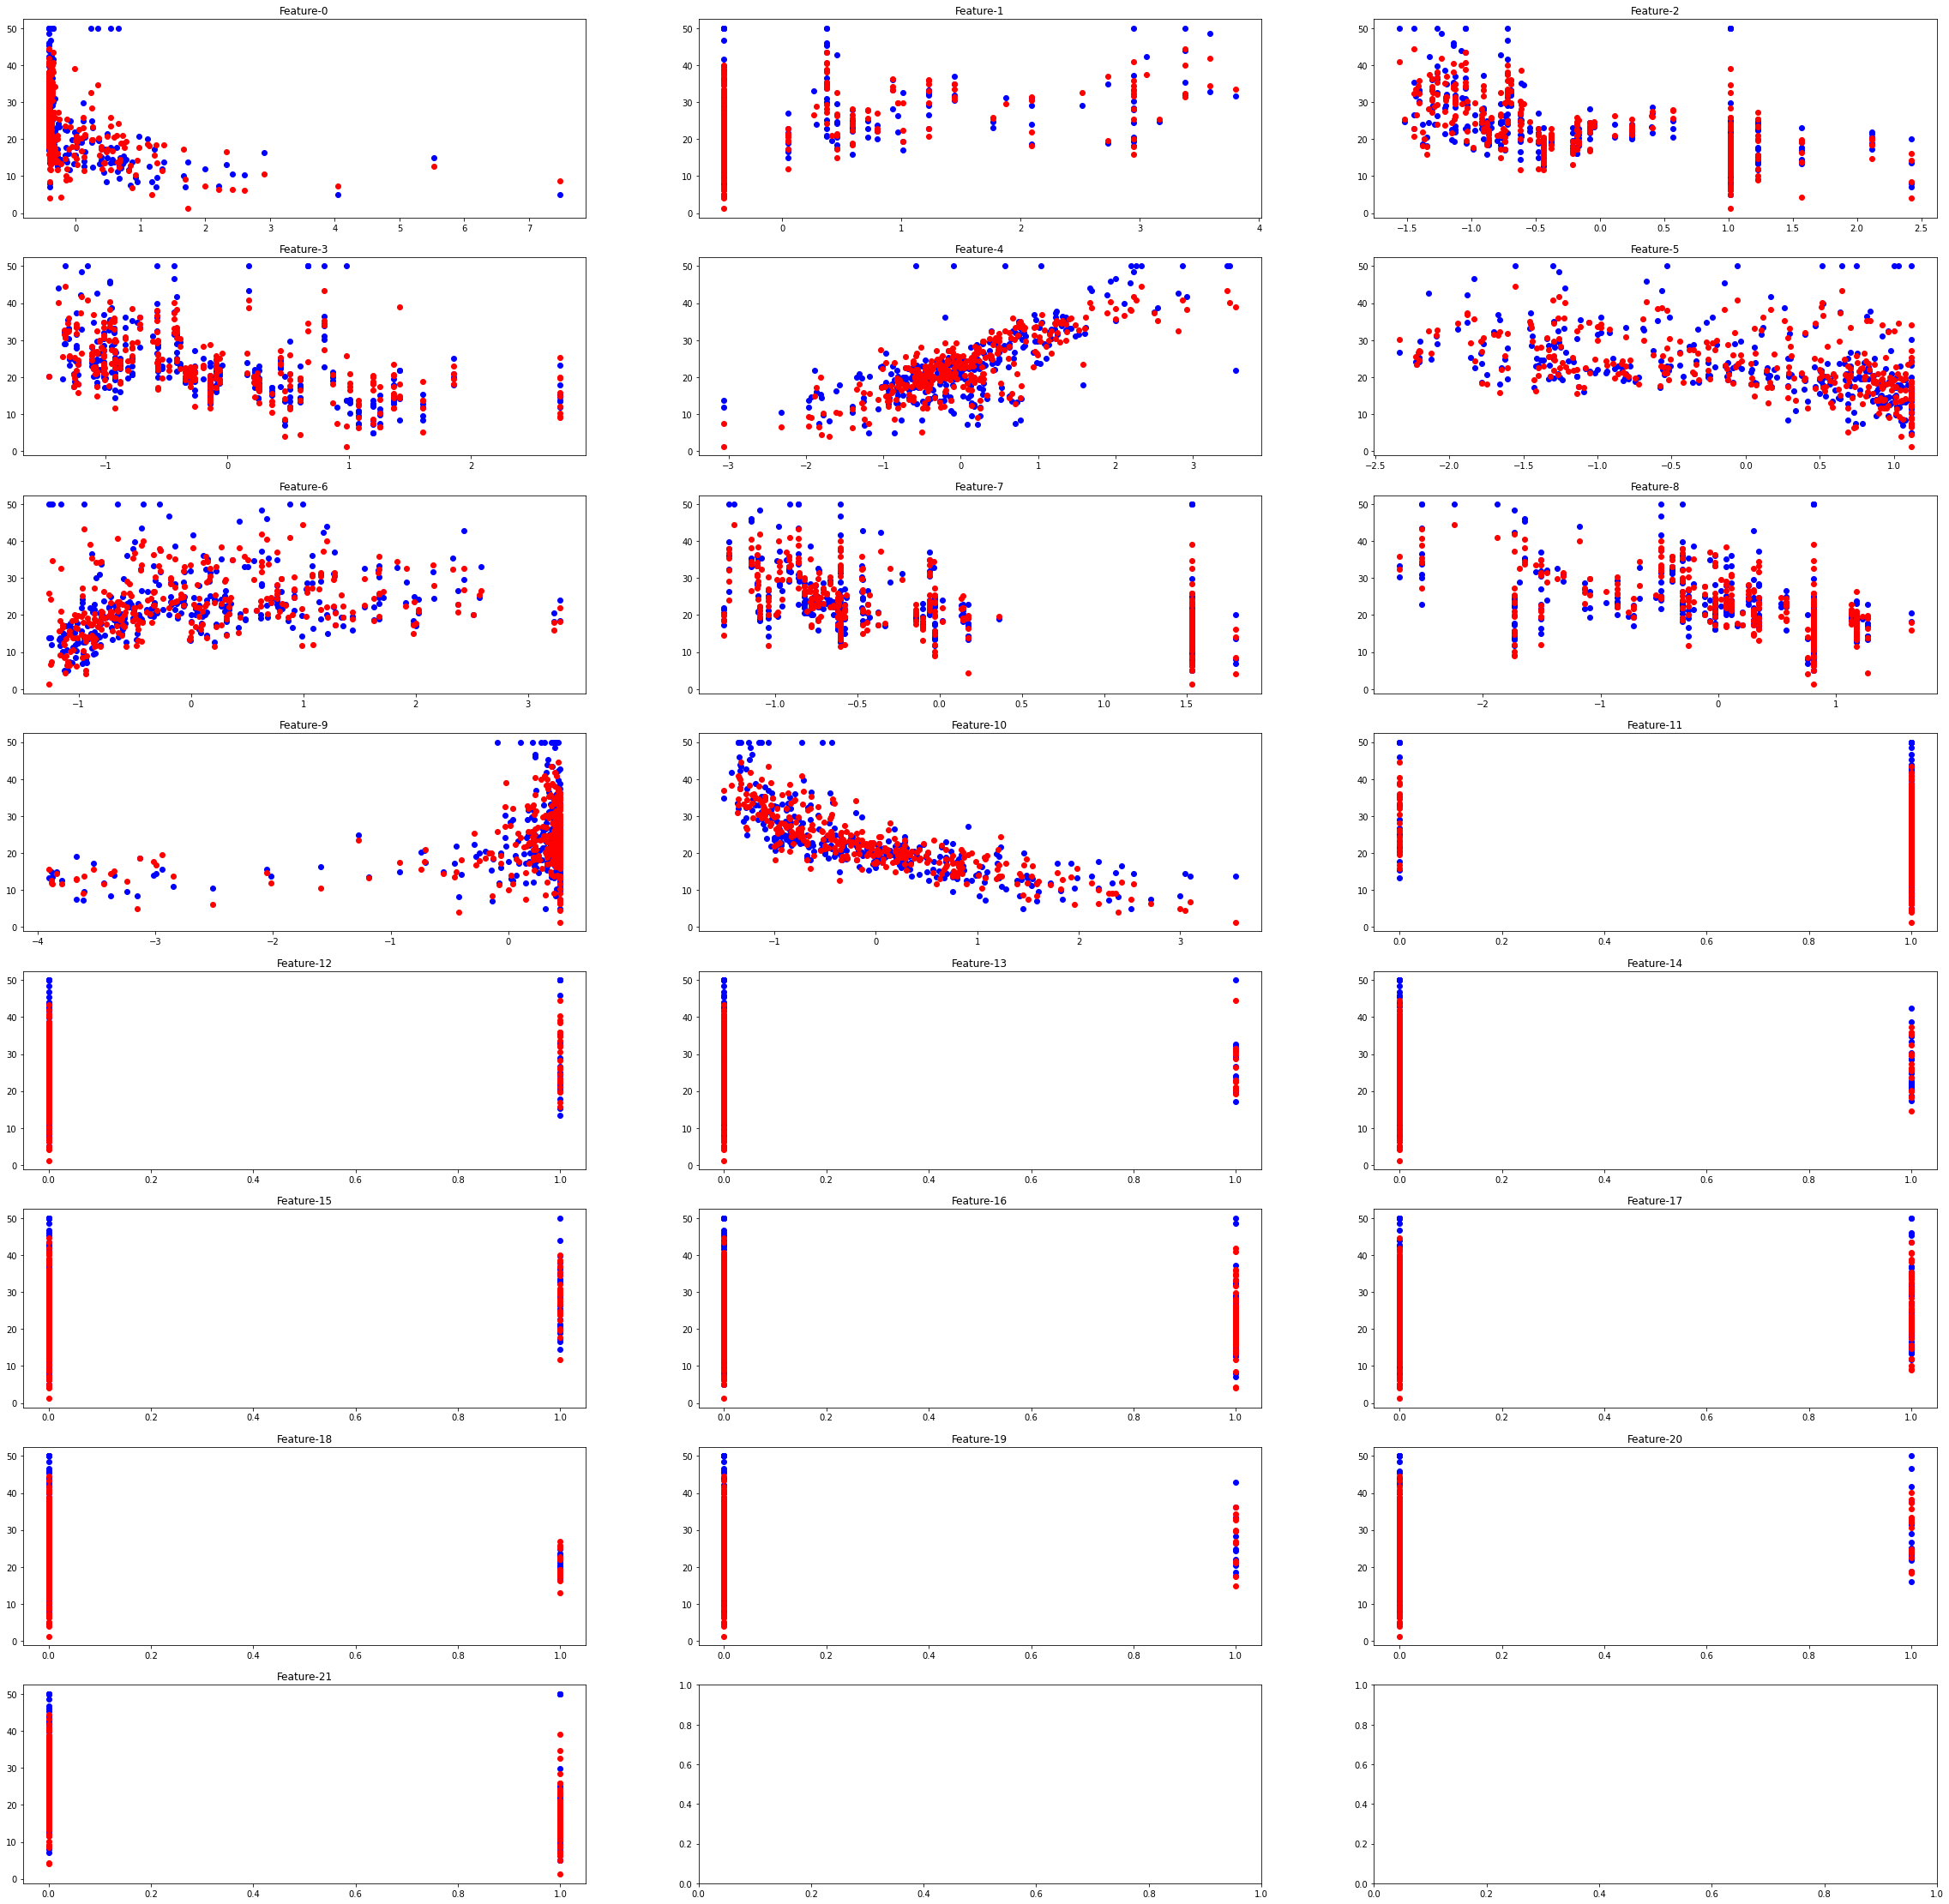

In [159]:
show_predication_result(X_train,y_train,lr_model.predict(X_train))

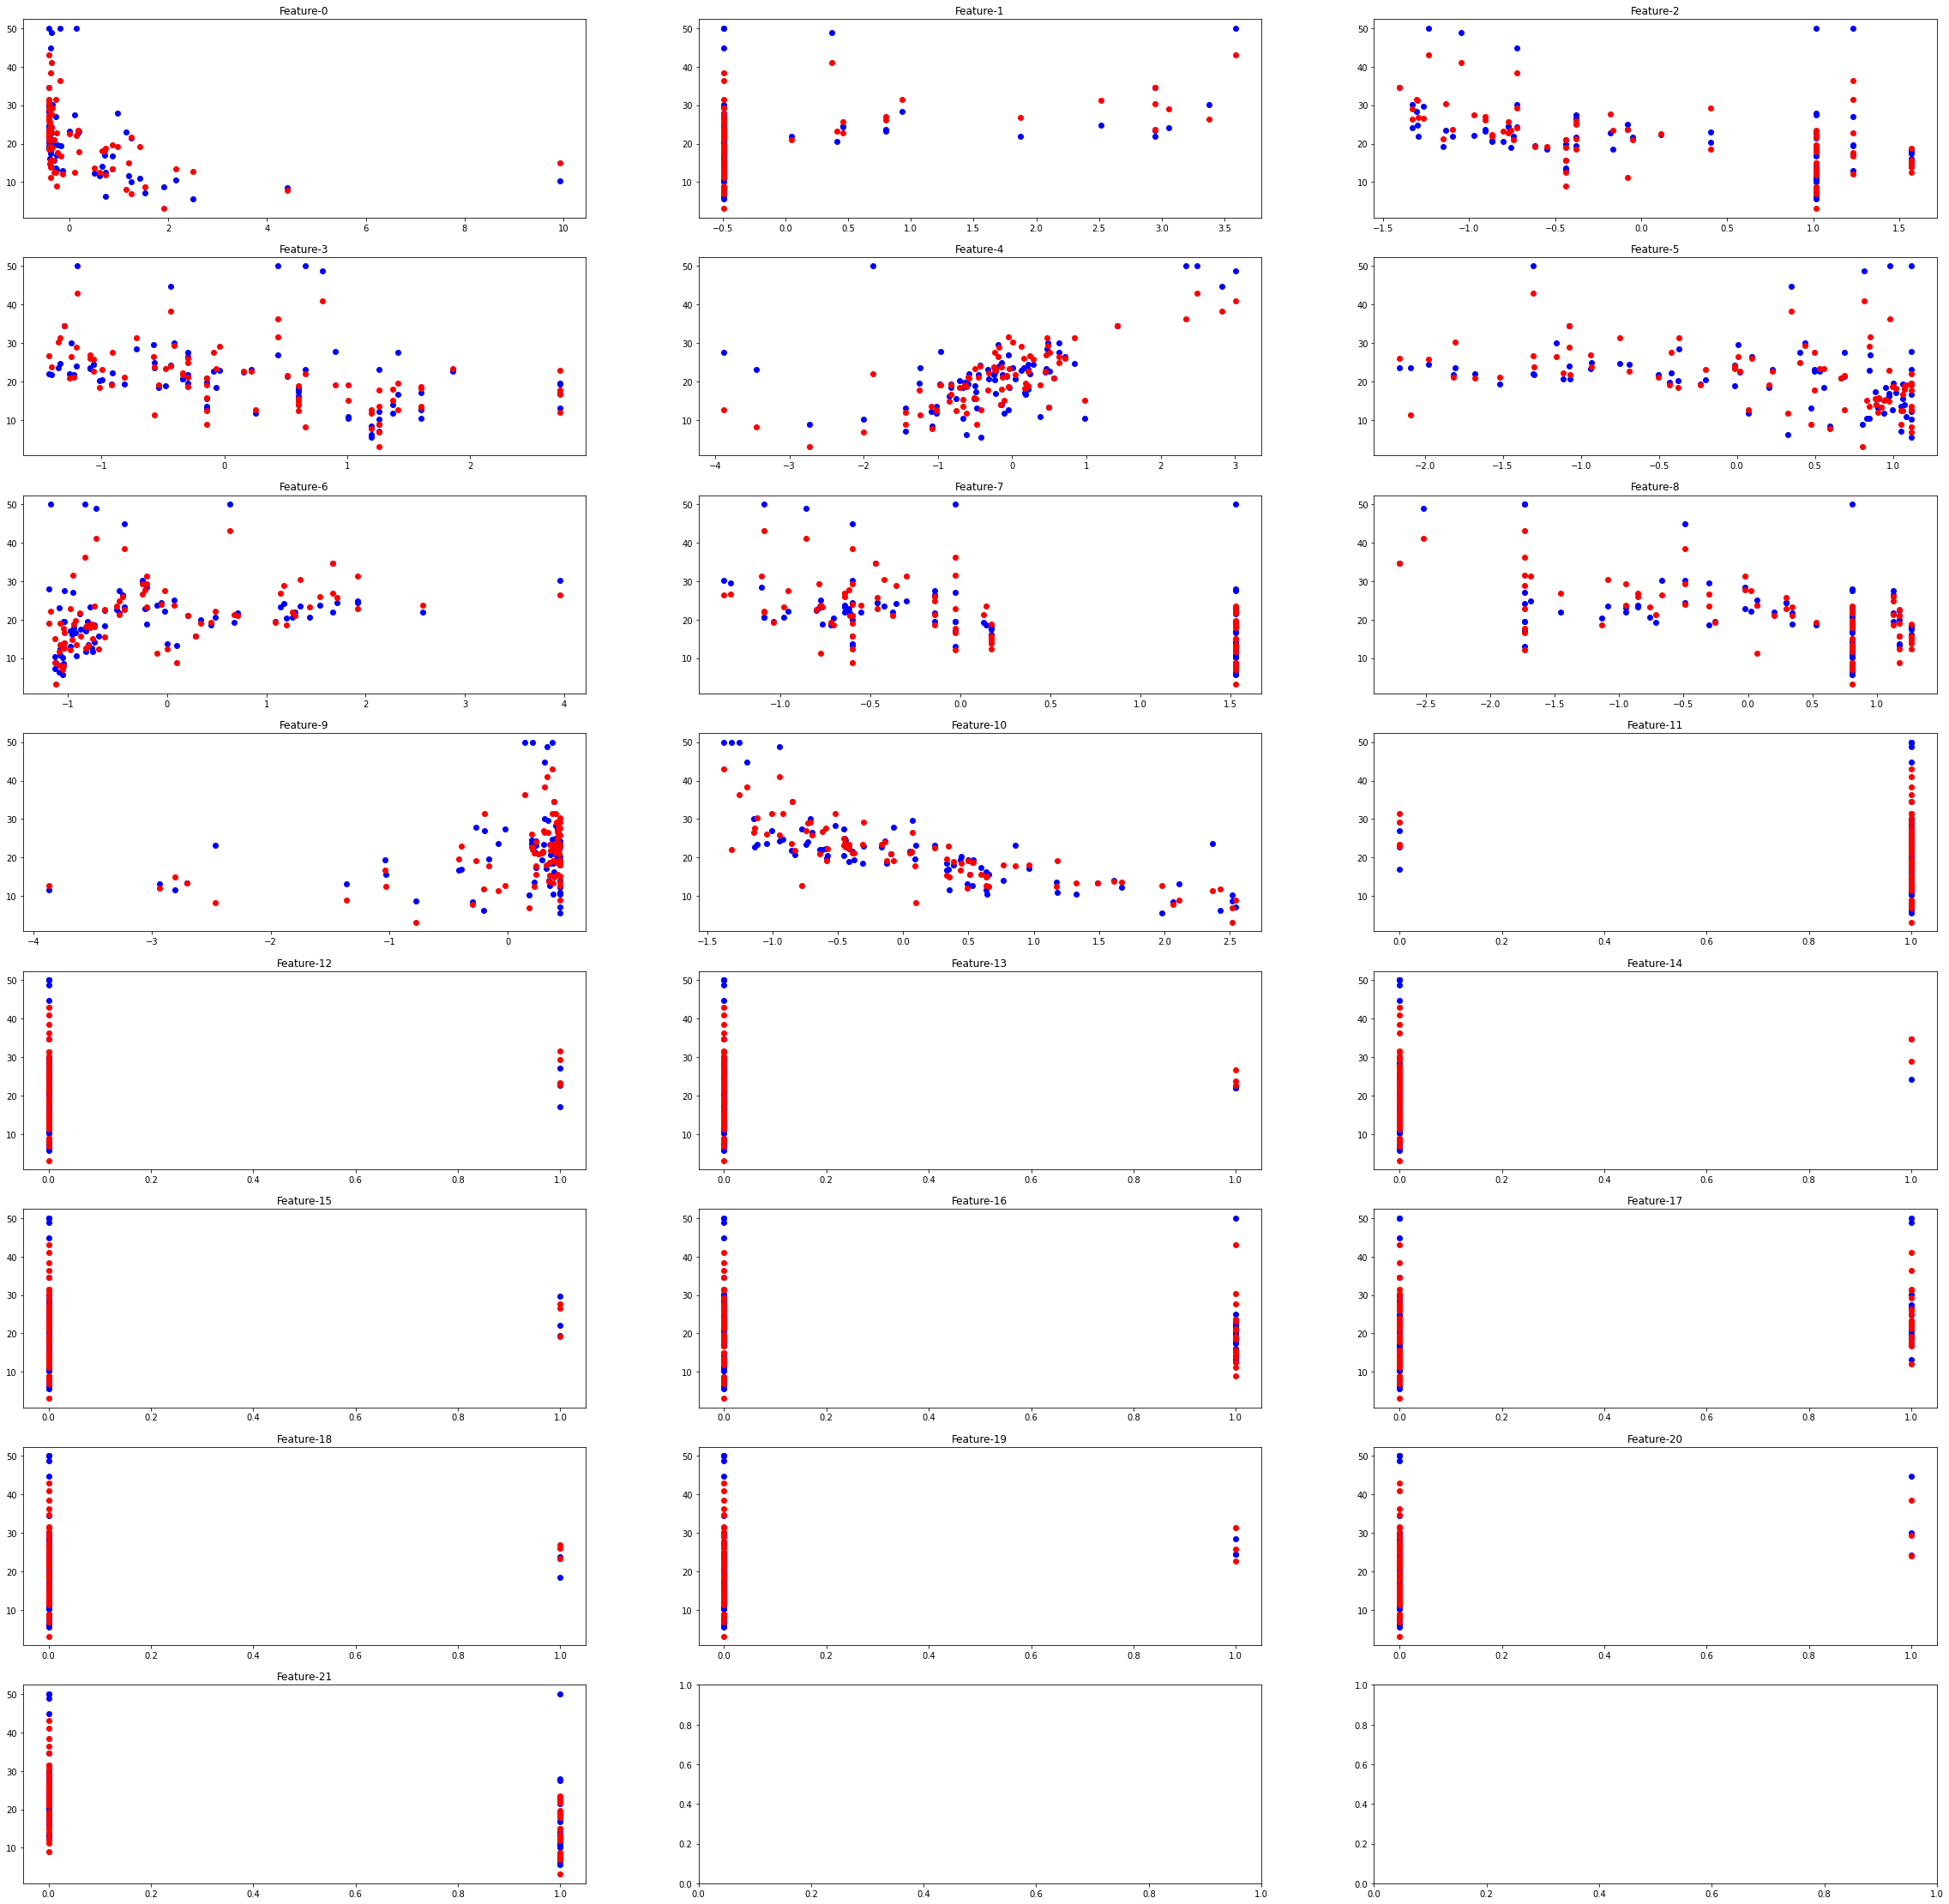

In [163]:
show_predication_result(X_val,y_val,lr_model.predict(X_val))

## 过拟合，可优化的空间，Outlinear （异常值）

# Part2. Logistic Regression, multi-class

1. Data 
+ Pre-processing 
+ Feature-Extractor
+ Split Training, Test, Validation
+ Build Model
+ Gradient Descent 
+ Evaluation
+ Predicat
+ Analysis

## Preprocession

In [164]:
from struct import unpack

In [165]:
def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

In [167]:
train_x, train_y = loadmnist('chap4ML2/课程代码/dataset/t10k-images-idx3-ubyte', 'chap4ML2/课程代码/dataset/t10k-labels-idx1-ubyte')

In [168]:
test_x, test_y = loadmnist('chap4ML2/课程代码/dataset/train-images-idx3-ubyte', 'chap4ML2/课程代码/dataset/train-labels-idx1-ubyte')

In [169]:
train_x.shape

(10000, 784)

In [174]:
test_y.shape[0]

60000

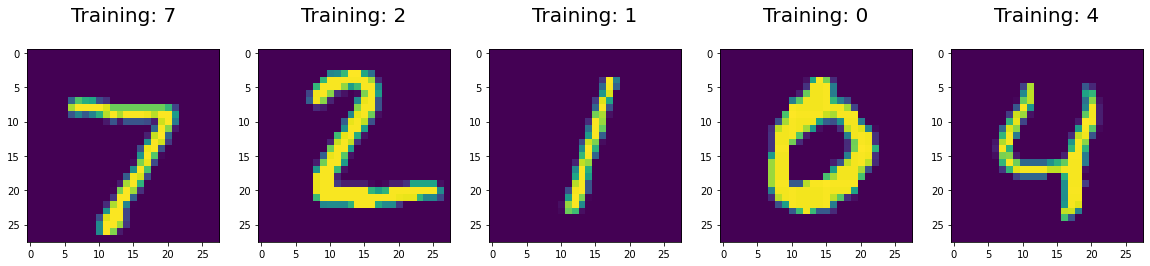

In [170]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_x[0:5], train_y[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)))
    plt.title('Training: %i\n' % label, fontsize = 20)

## bulit-in Softmax

x(784维度，)
w(784维度，10类) 
b(1, 10类)



如果用softmax，先做标准化，避免y值太大，导致exp(y)溢出

为什么用softmax，其中一个原因即使某一类的y=0，也能soft出一个概率来

In [217]:
train_x_std = stander.fit_transform(train_x)

In [219]:
w, b = np.random.rand(28*28,10), np.random.random(10)
print(w.shape)

(784, 10)


In [220]:
y_pred = np.dot(w.T, train_x_std[0])+b
y_pred

array([-49.80528762, -34.49857225, -37.83141189, -36.55875323,
       -29.63545694, -50.76429119, -37.03028559, -51.04321684,
       -44.73634127, -42.03400504])

In [221]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [222]:
softmax(y_pred)

array([1.72267007e-09, 7.65286636e-03, 2.73143119e-04, 9.75211687e-04,
       9.90485840e-01, 6.60255686e-10, 6.08576243e-04, 4.99546913e-10,
       2.73916084e-07, 4.08533100e-06])

In [261]:
def grad_sigmoid(w,b,x,y):
    # forward
    l = np.dot(train_x_std, w)+b
    s = np.exp(l)/np.sum(np.exp(l))
    loss = [-np.log(s[i][y-1]) for i,y in enumerate(y)]
    print('loss is: ',loss)


In [262]:
grad_sigmoid(w, b, train_x_std, train_y)

loss is:  [398.9936771857389, 253.06314550152763, 450.85748398436294, 324.8441343658531, 413.7567913814931, 434.04994830541915, 395.721717208076, 341.45107602714535, 323.01516783398387, 336.66793930543264, 351.21934662455266, 357.58553673580906, 395.73871332780317, 358.8291478792747, 424.33606339185513, 381.6766231712381, 387.5609514556867, 363.6828856918266, 266.1533428425916, 431.9416473956296, 370.0838579730538, 382.2238733741848, 381.7784895781621, 391.41349529077496, 442.5406728875368, 209.21484798239868, 411.1368713254716, 403.2343462744281, 335.734581587114, 439.0742738215088, 381.66494007565285, 455.4080978472785, 366.33301583987065, 365.21984866393325, 357.64636688867296, 340.817057614103, 371.6462286764383, 439.3964024724048, 408.7543983959957, 412.2815750102963, 472.1126793538212, 422.77822752596364, 386.88204918106584, 420.65854344948076, 409.7174644930373, 409.7306469369983, 412.52477196700903, 385.4482104312771, 316.25706237850227, 383.1741372490012, 395.1604689013045, 29

In [234]:
train_y.shape

(10000,)